Comparing two dimensionality reduction methods 
- univariate feature selection with ANOVA 
- feature agglomeration with Ward hierarchical clustering 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 

from scipy import linalg, ndimage  
from joblib import Memory 

import shutil 
import tempfile 

from sklearn.feature_extraction.image import grid_to_graph 
from sklearn import feature_selection 
from sklearn.cluster import FeatureAgglomeration 
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import BayesianRidge 
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
#setting parameters 

n_samples = 200 
size = 40 
roi_size = 15 
snr = 5.0 
np.random.seed(0)

In [3]:
#Generating data 

coef = np.zeros((size, size))
coef[0:roi_size, 0:roi_size] = -1.0 
coef[-roi_size, -roi_size] = 1.0 

X = np.random.randn(n_samples, size ** 2)
for x in X:
    x[:] = ndimage.gaussian_filter(x.reshape(size, size), sigma=1.0).ravel()
X -= X.mean(axis=0)
X /= X.std(axis=0)

y = np.dot(X, coef.ravel())

In [4]:
#add noise 

noise = np.random.randn(y.shape[0])
noise_coef = (linalg.norm(y, 2) / np.exp(snr /20.0)) / linalg.norm(noise, 2)
y += noise_coef * noise 

In [5]:
#compute the coefs of a Bayesian Ridge with GridSearch 

cv = KFold(2) 
ridge = BayesianRidge()
cachedir = tempfile.mkdtemp()
mem = Memory(location=cachedir, verbose=1)

In [6]:
#Ward Agglomeration followed by BayesianRidge 

connectivity = grid_to_graph(n_x=size, n_y=size)
ward = FeatureAgglomeration(n_clusters=10, connectivity=connectivity, memory=mem)

clf = Pipeline([("ward", ward),("ridge", ridge)])

#select the optimal number of parcels with grid search 

clf = GridSearchCV(clf, {"ward__n_clusters":[10,20,30]}, n_jobs=1, cv=cv)
clf.fit(X,y)

coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_)
coef_agglomeration_ = coef_.reshape(size, size)

________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[-0.451933, ..., -0.675318],
       ...,
       [ 0.275706, ..., -1.085711]]), connectivity=<1600x1600 sparse matrix of type '<class 'numpy.int32'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[ 0.905206, ...,  0.161245],
       ...,
       [-0.849835, ..., -1.091621]]), connectivity=<1600x1600 sparse matrix of type '<class 'numpy.int32'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.0s, 0.0min
__________________________________________

ANOVA univariate feature selection followed by BAyesian Ridge 


In [7]:
f_regression = mem.cache(feature_selection.f_regression) #caching function 

anova = feature_selection.SelectPercentile(f_regression)
clf = Pipeline([("anova",anova), ("ridge",ridge)])

clf = GridSearchCV(clf, {"anova__percentile":[5, 10, 20]}, cv=cv)
clf.fit(X, y)

coef_ = clf.best_estimator_.steps[-1][1].coef_ 
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_.reshape(1,-1))
coef_selection_ = coef_.reshape(size, size)

________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[-0.451933, ...,  0.275706],
       ...,
       [-0.675318, ..., -1.085711]]), 
array([48.315095, ..., 27.619534]))
_____________________________________________________f_regression - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[ 0.905206, ..., -0.849835],
       ...,
       [ 0.161245, ..., -1.091621]]), 
array([-61.330139, ..., -71.427245]))
_____________________________________________________f_regression - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[ 0.905206, ..., -0.849835],
       ...,
       [-0.675318

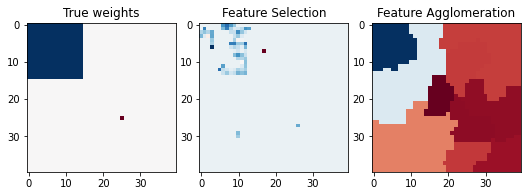

In [8]:
#inversing the transform to plot the results on an image 

plt.close("all")
plt.figure(figsize=(7.3, 2.7))
plt.subplot(1,3,1)
plt.imshow(coef, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("True weights")
plt.subplot(1,3,2)
plt.imshow(coef_selection_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Selection")
plt.subplot(1, 3, 3)
plt.imshow(coef_agglomeration_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Agglomeration")
plt.subplots_adjust(0.04, 0.0, 0.98, 0.94, 0.16, 0.26)
plt.show()
